In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

import torch.utils.data as data


import matplotlib.pyplot as plt
import numpy as np

In [3]:
import copy

import os

import time

In [4]:
from tqdm import tqdm

In [ ]:
!git clone https://github.com/KuoYuChang/MLDL_video_course.git
%cd MLDL_video_course

In [5]:
from utils.plot_tools import normalize_image, plot_images

In [6]:
from torch.optim.lr_scheduler import StepLR

from torchsummary import summary

We'll be using our own dataset instead of using one provided by `torchvision.datasets`.

The url of the CUB200-2011 dataset can be found on its [website](http://www.vision.caltech.edu/visipedia/CUB-200-2011.html). However, the dataset is now hosted on Google Drive which has problems with files exceeding their download quota.

Instead, we'll download the dataset from [Kaggle](https://www.kaggle.com) using the [kaggle-api](https://github.com/Kaggle/kaggle-api) which needs to be installed with `pip install kaggle`.

First, we need to have a Kaggle account in order to generate an API key. Once we're logged on to Kaggle, we need to go to `https://www.kaggle.com/<username>/account` and click `Generate New API Token` which will download a `kaggle.json` file. Place this at `~/.kaggle/kaggle.json` (or, if you're on Windows, at `C:\Users\<Windows-username>\.kaggle\kaggle.json`).

If we are using Google Colab, an alternative is simply set the environment variables `KAGGLE_USERNAME` and `KAGGLE_KEY` to their respective values. This is what we do below.

Next, we'll download the dataset from where it is hosted on Kaggle, at: https://www.kaggle.com/veeralakrishna/200-bird-species-with-11788-images. This is done with `!kaggle datasets download <kaggle-url> --unzip`, where the `<kaggle-url>` is the dataset URL after the `kaggle.com` part, which is `veeralakrishna/200-bird-species-with-11788-images` for this dataset.

[`datasets.utils`](https://github.com/pytorch/vision/blob/master/torchvision/datasets/utils.py) contains some functionality for downloading and extract data which means we don't have to write it ourselves.

We use the `extract_archive` function, which extracts a file to a given root folder. We should now have a `data/CUB_200_2011` folder which contains our entire dataset.

# REPLACE THESE WITH YOUR OWN KAGGLE USERNAME AND KEY
os.environ['KAGGLE_USERNAME'] = 'YOUR_KAGGLE_USERNAME_HERE'
os.environ['KAGGLE_KEY'] = 'YOUR_KAGGLE_KEY_HERE'

!pip install kaggle
!kaggle datasets download veeralakrishna/200-bird-species-with-11788-images --unzip

ROOT = 'data'

datasets.utils.extract_archive('CUB_200_2011.tgz', ROOT)

To handle using custom datasets, torchvision provides a [`datasets.ImageFolder`](https://pytorch.org/vision/stable/datasets.html#torchvision.datasets.ImageFolder) class.

`ImageFolder` expects data to be stored in the following way:

```
root/class_x/xxy.png
root/class_x/xxz.jpg

root/class_y/123.jpeg
root/class_y/nsdf3.png
root/class_y/asd932_.jpg
```

That is, each folder in the root directory is the name of a class, and within each of those folders are the images that correspond to that class. The images in the downloaded dataset are currently in the form of:

```
CUB_200_2011/images/class_a/image_1.jpg
CUB_200_2011/images/class_a/image_2.jpg

CUB_200_2011/images/class_b/image_1.jpg
CUB_200_2011/images/class_b/image_2.jpg

CUB_200_2011/images/class_c/image_1.jpg
CUB_200_2011/images/class_c/image_2.jpg
```

This means we could call `datasets.ImageFolder(root = '.data/CUB_200_2011/images)` and it would load all of the data. However, we want to split our data into train and test splits. This could be done with `data.random_split`, which we have used in the past to create our validation sets - but we will show how to manually create a `train` and `test` folder and store the relevant images in those folders. This way means that we only need to create a train/test split once and re-use it each time we re-run the notebook

We first set a `TRAIN_RATIO` which will decide what percentage of the images per class are used to make up the training set, with the remainder making up the test set. We create a `train` and `test` folder within the `CUB_200_2011` folder - after first deleting them if they already exist. Then, we get a list of all classes and loop through each class. For each class we get the image names, use the first `TRAIN_RATIO` of them for the training set and the remainder for the test set. We then copy - with `shutil.copyfile` - each of the images into their respective `train` or `test` folder. It is usually better to copy, rather than move, the images to create your custom splits just in case we accidentally mess up somewhere.

After running the below cell we have our training set as:

```
CUB_200_2011/images/train/class_a/image_1.jpg
CUB_200_2011/images/train/class_a/image_2.jpg

CUB_200_2011/images/train/class_b/image_1.jpg
CUB_200_2011/images/train/class_b/image_2.jpg

CUB_200_2011/images/train/class_b/image_1.jpg
CUB_200_2011/images/train/class_b/image_2.jpg
```

and our test set as:

```
CUB_200_2011/images/test/class_a/image_48.jpg
CUB_200_2011/images/test/class_a/image_49.jpg

CUB_200_2011/images/test/class_b/image_48.jpg
CUB_200_2011/images/test/class_b/image_49.jpg

CUB_200_2011/images/test/class_c/image_48.jpg
CUB_200_2011/images/test/class_c/image_49.jpg
```

This train/test split only needs to be created once and does not need to be created again on subsequent runs.

**Note:** `ImageFolder` will only load files that have image related extensions, i.e. jpg/jpeg/png, so if there was, for example, a `.txt` file in one of the class folders then it would not be loaded with the images. If we wanted more flexibility when deciding which files to load or not - such as not loading .png images or loading images with an esoteric format - then we could either use the `is_valid_file` argument of the `ImageFolder` class or use [`DatasetFolder`](https://pytorch.org/vision/stable/datasets.html#torchvision.datasets.DatasetFolder) and provide a list of valid extensions to the `extensions` argument.

## Alternating way
### go to  https://www.kaggle.com/veeralakrishna/200-bird-species-with-11788-images
### manually download, unzip, to get folder CUB_200_2011
### put to folder ./data
```
.
├──── ...
├──── data
│       ├──── CUB_200_2011
├──── Bird_FC.ipynb
└──── ...
```

In [7]:
ROOT = '.\\data'

TRAIN_RATIO = 0.8

data_dir = os.path.join(ROOT, 'CUB_200_2011')
images_dir = os.path.join(data_dir, 'images')
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

In [ ]:


if os.path.exists(train_dir):
    shutil.rmtree(train_dir)
if os.path.exists(test_dir):
    shutil.rmtree(test_dir)

os.makedirs(train_dir)
os.makedirs(test_dir)

classes = os.listdir(images_dir)

for c in classes:

    class_dir = os.path.join(images_dir, c)

    images = os.listdir(class_dir)

    n_train = int(len(images) * TRAIN_RATIO)

    train_images = images[:n_train]
    test_images = images[n_train:]

    os.makedirs(os.path.join(train_dir, c), exist_ok = True)
    os.makedirs(os.path.join(test_dir, c), exist_ok = True)

    for image in train_images:
        image_src = os.path.join(class_dir, image)
        image_dst = os.path.join(train_dir, c, image)
        shutil.copyfile(image_src, image_dst)

    for image in test_images:
        image_src = os.path.join(class_dir, image)
        image_dst = os.path.join(test_dir, c, image)
        shutil.copyfile(image_src, image_dst)

Now we've got our train/test splits we can go ahead and calculate the mean and standard deviation (std) of our dataset to normalize it. We're actually going to use a pre-trained model in this notebook so will be using the mean and std desired by the pre-trained data, so we don't actually have to calculate this - however it is left as an example.

Calculating the mean and std is slightly different than when using a dataset provided by torchvision as those datasets have all of the images stored as numpy arrays in the data's `data` attribute, whilst datasets loaded by `ImageFolder` and `DataFolder` do not.

First, we load the `train_data` from the `train` folder. Remember: the mean and std must only be calculated from the training data. This will load PIL images by default so we pass the `ToTensor` transform which converts all the PIL images to tensors and scales them from 0-255 to 0-1.

We then loop through each image and calculate the mean and std across the height and width dimensions with `dim = (1,2)`, summing all the means and stds and then finding the average by dividing them by the number of examples, `len(train_data)`.

Again, this only needs to be calculated once per dataset and the means and stds calculated here can be re-used without calculating them for other runs. The exception to this is if we used a different train/test split, then we would need to calculate these again.

### this step may be skip

In [7]:
train_data = datasets.ImageFolder(root = train_dir,
                                  transform = transforms.ToTensor())

means = torch.zeros(3)
stds = torch.zeros(3)

for img, label in train_data:
    means += torch.mean(img, dim = (1,2))
    stds += torch.std(img, dim = (1,2))

means /= len(train_data)
stds /= len(train_data)

print(f'Calculated means: {means}')
print(f'Calculated stds: {stds}')

Calculated means: tensor([0.4862, 0.4999, 0.4315])
Calculated stds: tensor([0.1821, 0.1811, 0.1931])


Now to actually load our data. As we are going to be using a pre-trained model we will need to ensure that our images are the same size and have the same normalization as those used to train the model - which we find on the torchvision [models](https://pytorch.org/vision/stable/models.html) page.

We use the same data augmentation as always: randomly rotating, flipping horizontally and cropping.

In [8]:
pretrained_size = 224

# set pretrained means and stds
pretrained_means = [0.4862, 0.4999, 0.4315]
pretrained_stds= [0.1821, 0.1811, 0.1931]

train_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.RandomRotation(5),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(pretrained_size, padding = 10),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pretrained_means,
                                                std = pretrained_stds)
                       ])

test_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.CenterCrop(pretrained_size),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pretrained_means,
                                                std = pretrained_stds)
                       ])

We load our data with our transforms...

In [9]:
train_data = datasets.ImageFolder(root = train_dir,
                                  transform = train_transforms)

test_data = datasets.ImageFolder(root = test_dir,
                                 transform = test_transforms)

...create the validation split...

In [10]:
VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data,
                                           [n_train_examples, n_valid_examples])

...and then overwrite the validation transforms, making sure to do a `deepcopy` to stop this also changing the training data transforms.

In [11]:
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

To make sure nothing has messed up we'll print the number of examples in each of the data splits - ensuring they add up to the number of examples indicated on the [CUB200-2011 dataset website](http://www.vision.caltech.edu/visipedia/CUB-200-2011.html) (11,788).

In [12]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 8472
Number of validation examples: 942
Number of testing examples: 2374


Next, we'll create the iterators with the largest batch size that fits on our GPU.

In [13]:
BATCH_SIZE = 4

train_iterator = data.DataLoader(train_data,
                                 shuffle = True,
                                 batch_size = BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data,
                                 batch_size = BATCH_SIZE)

test_iterator = data.DataLoader(test_data,
                                batch_size = BATCH_SIZE)

To ensure the images have been processed correctly we can plot a few of them - ensuring we re-normalize the images so their colors look right.

We can see the images look fine, however the names of the classes provided by the folders containing the images are a little long and sometimes overlap with neighbouring images.

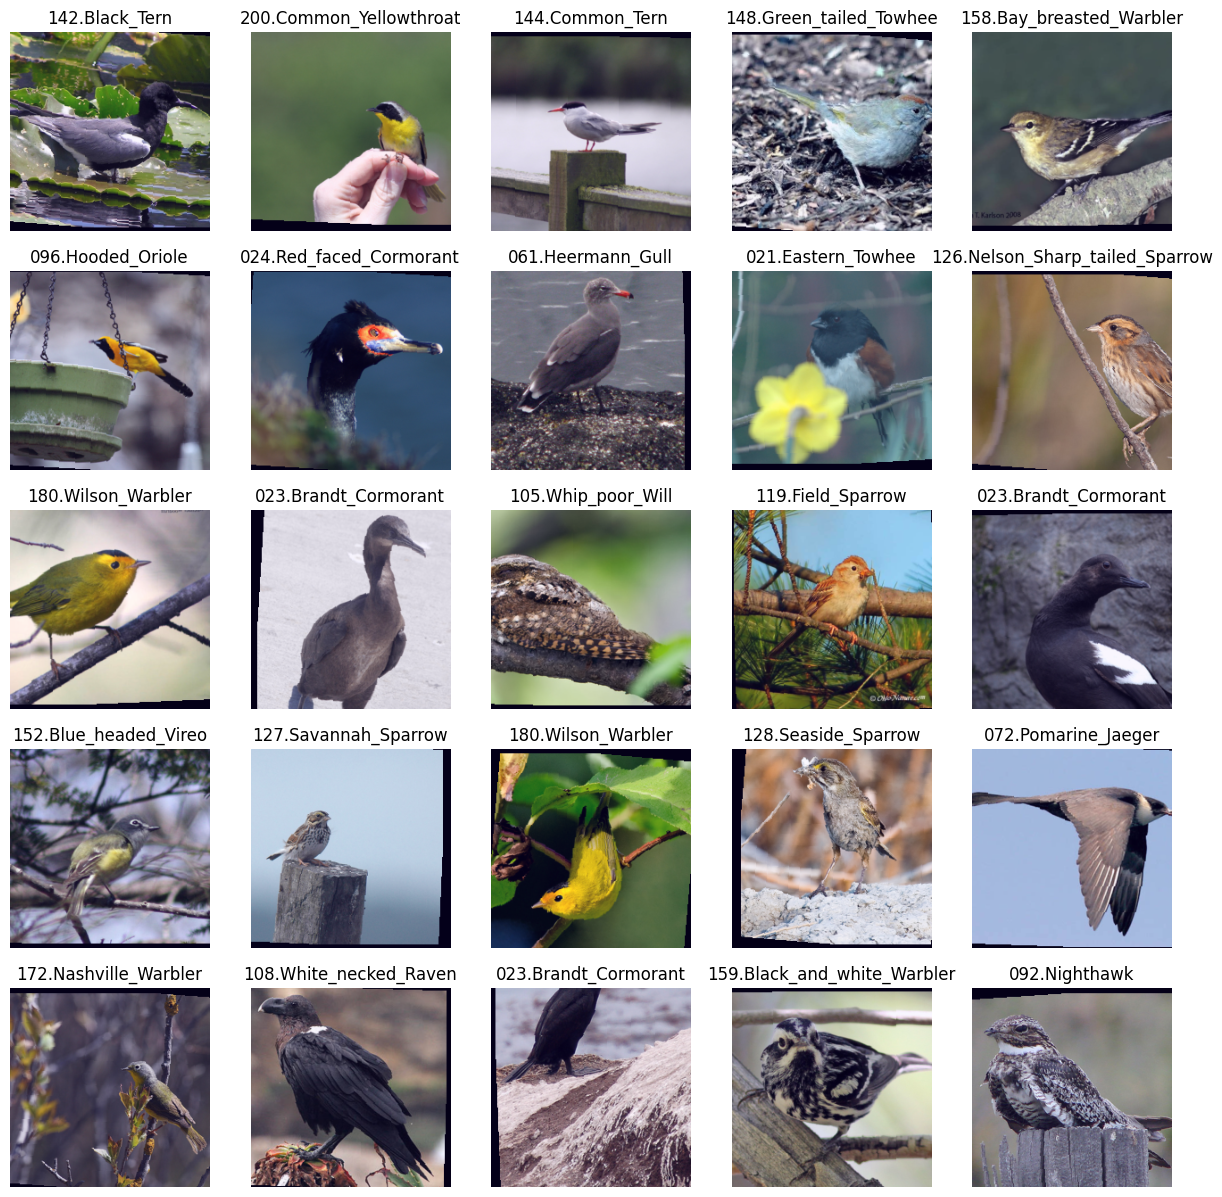

In [14]:
N_IMAGES = 25

images, labels = zip(*[(image, label) for image, label in
                           [train_data[i] for i in range(N_IMAGES)]])

classes = test_data.classes

plot_images(images, labels, classes)

One way to solve the issue with the names of the classes would have been to manually change the names of the folders before we copied them over into the `train` and `test` folders.

Another approach is to directly change the names of each class provided by the dataset's `.classes`. We'll make a `format_label` function which will strip off the number at the start of each class and convert them into title case.

In [15]:
def format_label(label):
    label = label.split('.')[-1]
    label = label.replace('_', ' ')
    label = label.title()
    label = label.replace(' ', '')
    return label

Let's change the class names and re-plot the images with their new class names.

No more overlapping!

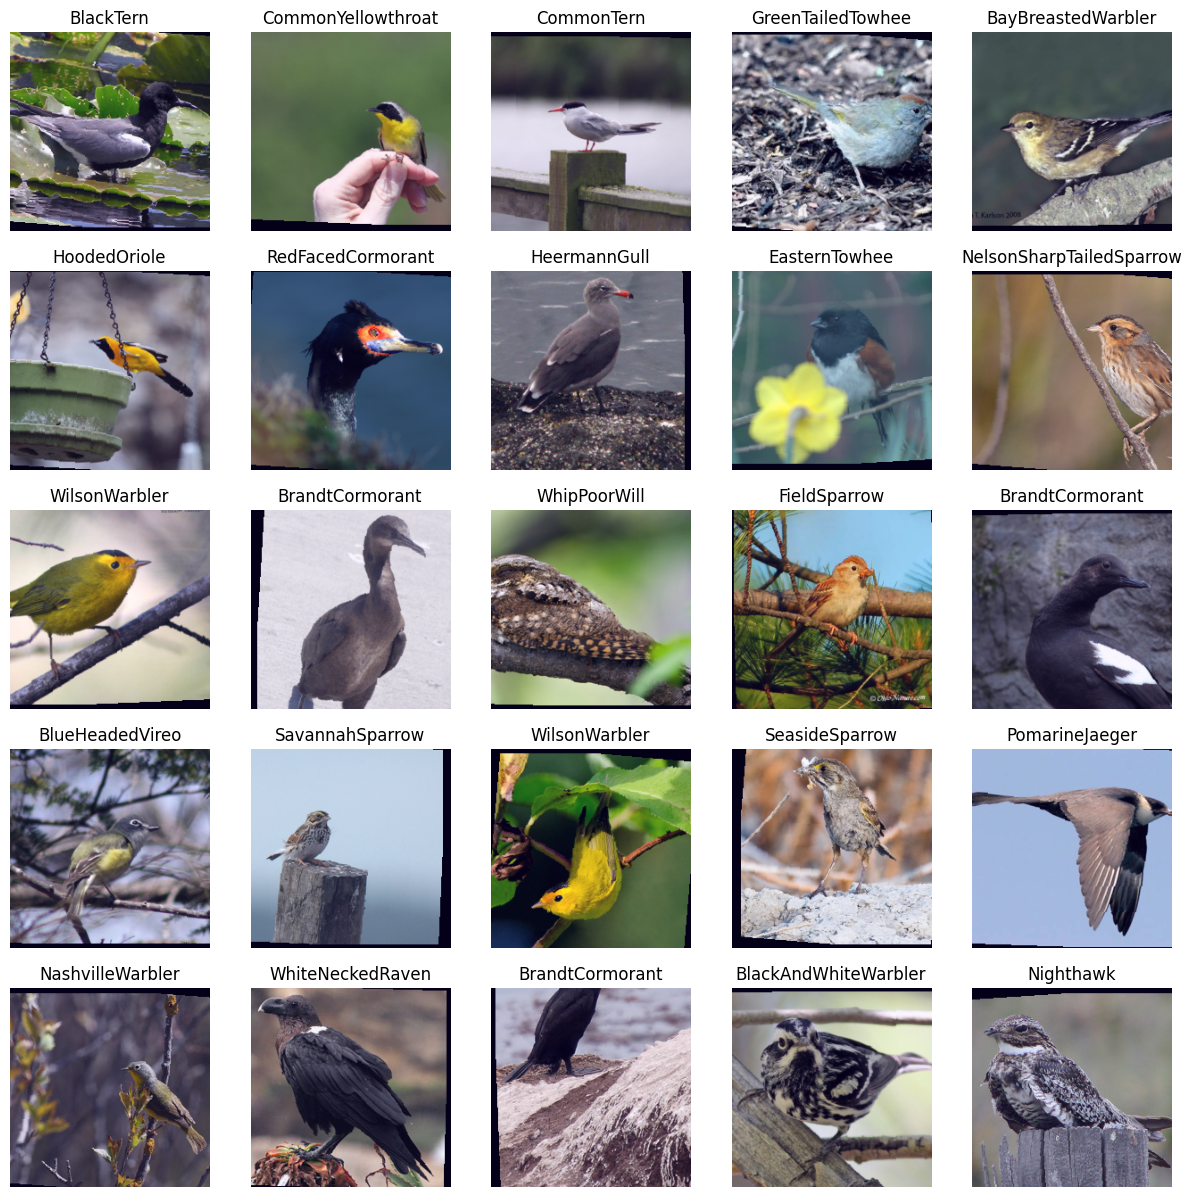

In [16]:
test_data.classes = [format_label(c) for c in test_data.classes]

classes = test_data.classes

plot_images(images, labels, classes)

### Build neural network

#### as mnist network

In [17]:
len(train_data[0])

2

In [18]:
train_data[0][0].shape

torch.Size([3, 224, 224])

In [19]:
num_class = len(test_data.classes)

In [ ]:
'''
class Net(nn.Module):
    def __init__(self, input_shape, lr=1.0, gamma=0.7):
        super(Net, self).__init__()

        flat_len = input_shape[0] * input_shape[1] * input_shape[2]

        # first as mnist, only 2 layers
        # then consider change back to 2048?
        
        self.fc1 = nn.Linear(flat_len, 2048)
        self.bt1 = nn.BatchNorm1d(2048)
        
        
        self.fc_last = nn.Linear(2048, num_class)

        self.CE = nn.CrossEntropyLoss()

        # optimizer, scheduler
        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        #self.scheduler = StepLR(self.optimizer, step_size=1, gamma=gamma)

    def forward(self, x):
        
        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.bt1(x)

        # consider add batch normalzition?
        x = self.fc_last(x)
        output = F.log_softmax(x, dim=1)
        return output

    def train_step(self, inputs, labels):
        # input should already be in device
        
        # output
        outputs = model(inputs)
        

        # loss
        loss = self.CE(outputs, labels)
        loss.backward()
        

        # optimize
        self.optimizer.step()

        return outputs, loss.item()
        '''

In [ ]:
class Net(nn.Module):
    def __init__(self, input_shape, lr=1.0, gamma=0.7):
        super(Net, self).__init__()

        flat_len = input_shape[0] * input_shape[1] * input_shape[2]

        # first as mnist, only 2 layers
        # then consider change back to 2048?
        
        self.fc1 = nn.Linear(flat_len, 2048)
        self.bt1 = nn.BatchNorm1d(2048)
        self.fc2 = nn.Linear(2048, 2048)
        self.bt2 = nn.BatchNorm1d(2048)
        
        self.fc3 = nn.Linear(2048, 1536)
        self.bt3 = nn.BatchNorm1d(1536)
        self.fc4 = nn.Linear(1536, 1536)
        self.bt4 = nn.BatchNorm1d(1536)

        self.fc5 = nn.Linear(1536, 1024)
        self.bt5 = nn.BatchNorm1d(1024)
        self.fc6 = nn.Linear(1024, 1024)
        self.bt6 = nn.BatchNorm1d(1024)

        self.fc7 = nn.Linear(1024, 768)
        self.bt7 = nn.BatchNorm1d(768)
        self.fc8 = nn.Linear(768, 768)
        self.bt8 = nn.BatchNorm1d(768)
        
        self.fc9 = nn.Linear(768, 512)
        self.bt9 = nn.BatchNorm1d(512)
        self.fc10 = nn.Linear(512, 512)
        self.bt10 = nn.BatchNorm1d(512)
        
        
        self.fc_last = nn.Linear(512, num_class)

        self.CE = nn.CrossEntropyLoss()

        # optimizer, scheduler
        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        #self.scheduler = StepLR(self.optimizer, step_size=1, gamma=gamma)

    def forward(self, x):
        
        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.bt1(x)

        x = self.fc2(x)
        x = F.relu(x)
        x = self.bt2(x)

        x = self.fc3(x)
        x = F.relu(x)
        x = self.bt3(x)

        x = self.fc4(x)
        x = F.relu(x)
        x = self.bt4(x)

        x = self.fc5(x)
        x = F.relu(x)
        x = self.bt5(x)

        x = self.fc6(x)
        x = F.relu(x)
        x = self.bt6(x)

        x = self.fc7(x)
        x = F.relu(x)
        x = self.bt7(x)

        x = self.fc8(x)
        x = F.relu(x)
        x = self.bt8(x)

        x = self.fc9(x)
        x = F.relu(x)
        x = self.bt9(x)

        x = self.fc10(x)
        x = F.relu(x)
        x = self.bt10(x)

        # consider add batch normalzition?
        x = self.fc_last(x)
        output = F.log_softmax(x, dim=1)
        return output

    def train_step(self, inputs, labels):
        # input should already be in device
        
        # output
        outputs = model(inputs)
        

        # loss
        loss = self.CE(outputs, labels)
        loss.backward()
        

        # optimize
        self.optimizer.step()

        return outputs, loss.item()

In [21]:
input_shape = [3, 224, 224]
lr = 0.001

In [22]:
bird_fc = Net(lr=lr, input_shape=input_shape)

In [23]:
print(summary(bird_fc, input_size=(3, pretrained_size, pretrained_size) ))

Layer (type:depth-idx)                   Param #
├─Linear: 1-1                            308,283,392
├─BatchNorm1d: 1-2                       4,096
├─Linear: 1-3                            4,196,352
├─BatchNorm1d: 1-4                       4,096
├─Linear: 1-5                            3,147,264
├─BatchNorm1d: 1-6                       3,072
├─Linear: 1-7                            2,360,832
├─BatchNorm1d: 1-8                       3,072
├─Linear: 1-9                            1,573,888
├─BatchNorm1d: 1-10                      2,048
├─Linear: 1-11                           1,049,600
├─BatchNorm1d: 1-12                      2,048
├─Linear: 1-13                           787,200
├─BatchNorm1d: 1-14                      1,536
├─Linear: 1-15                           590,592
├─BatchNorm1d: 1-16                      1,536
├─Linear: 1-17                           393,728
├─BatchNorm1d: 1-18                      1,024
├─Linear: 1-19                           262,656
├─BatchNorm1d: 1-20     

### Training the model

In [24]:
EPOCHS = 30

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

bird_fc = bird_fc.to(device)
bird_fc.CE = bird_fc.CE.to(device)

In [25]:
model = bird_fc

One other thing we are going to implement is top-k accuracy. Our task is to classify an image into one of 200 classes of bird, however some of these classes look very similar and it is even difficult for a human to correctly label them. So, maybe we should be more lenient when calculating accuracy?

One method of solving this is using top-k accuracy, where the prediction is labelled correct if the correct label is in the top-k predictions, instead of just being the first. Our `calculate_topk_accuracy` function calculates the top-1 accuracy as well as the top-k accuracy, with $k=5$ by default.

We use `.reshape` instead of view here as the slices into tensors cause them to become non-contiguous which means `.view` throws an error. As a rule of thumb, if you are aiming to change the size/shape of sliced tensors then you should probably use `.reshape` instead of `.view`.

**Note:** our value of k should be chosen sensibly. If we had a dataset with 10 classes then a k of 5 isn't really that informative.

In [26]:
def calculate_topk_accuracy(y_pred, y, k = 5):
    with torch.no_grad():
        batch_size = y.shape[0]
        _, top_pred = y_pred.topk(k, 1)
        top_pred = top_pred.t()
        correct = top_pred.eq(y.view(1, -1).expand_as(top_pred))
        correct_1 = correct[:1].reshape(-1).float().sum(0, keepdim = True)
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim = True)
        acc_1 = correct_1 / batch_size
        acc_k = correct_k / batch_size
    return acc_1, acc_k

In [27]:
#def train(model, iterator, optimizer, criterion, scheduler, device):
def train(model, iterator, device):

    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0

    model.train()

    for (x, y) in tqdm(iterator):

        x = x.to(device)
        y = y.to(device)

        #optimizer.zero_grad()
        model.optimizer.zero_grad()

        #y_pred, _ = model(x)

        #loss = criterion(y_pred, y)

        #acc_1, acc_5 = calculate_topk_accuracy(y_pred, y)

        #loss.backward()

        #optimizer.step()

        #scheduler.step()

        output, loss = model.train_step(x, y)
        acc_1, acc_5 = calculate_topk_accuracy(output, y)
        

        #epoch_loss += loss.item()
        epoch_loss += loss
        epoch_acc_1 += acc_1.item()
        epoch_acc_5 += acc_5.item()

    # change to schedule after epoch finish
    #model.scheduler.step()
        
    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)

    return epoch_loss, epoch_acc_1, epoch_acc_5

In [28]:
#def evaluate(model, iterator, criterion, device):
def evaluate(model, iterator, device):

    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0

    model.eval()

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            #y_pred, _ = model(x)
            y_pred = model(x)

            #loss = criterion(y_pred, y)
            loss = model.CE(y_pred, y)


            acc_1, acc_5 = calculate_topk_accuracy(y_pred, y)

            #epoch_loss += loss.item()
            epoch_loss += loss.item()
            epoch_acc_1 += acc_1.item()
            epoch_acc_5 += acc_5.item()

    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)

    return epoch_loss, epoch_acc_1, epoch_acc_5

Next, a small helper function which tells us how long an epoch has taken.

In [29]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Finally, we can train our model!

See how we got top-1 and top-5 validation accuracy.

In [30]:
best_valid_loss = float('inf')

for epoch in range(EPOCHS):

    start_time = time.monotonic()

    #train_loss, train_acc_1, train_acc_5 = train(model, train_iterator, optimizer, criterion, scheduler, device)
    #valid_loss, valid_acc_1, valid_acc_5 = evaluate(model, valid_iterator, criterion, device)

    train_loss, train_acc_1, train_acc_5 = train(model, train_iterator, device)
    valid_loss, valid_acc_1, valid_acc_5 = evaluate(model, valid_iterator, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut5-model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc @1: {train_acc_1*100:6.2f}% | ' \
          f'Train Acc @5: {train_acc_5*100:6.2f}%')
    print(f'\tValid Loss: {valid_loss:.3f} | Valid Acc @1: {valid_acc_1*100:6.2f}% | ' \
          f'Valid Acc @5: {valid_acc_5*100:6.2f}%')

100%|██████████████████████████████████████████████████████████████████████████████| 2118/2118 [05:45<00:00,  6.13it/s]


Epoch: 01 | Epoch Time: 5m 54s
	Train Loss: 5.803 | Train Acc @1:   0.66% | Train Acc @5:   3.21%
	Valid Loss: 5.375 | Valid Acc @1:   0.53% | Valid Acc @5:   3.50%


100%|██████████████████████████████████████████████████████████████████████████████| 2118/2118 [05:51<00:00,  6.03it/s]


Epoch: 02 | Epoch Time: 6m 2s
	Train Loss: 5.492 | Train Acc @1:   0.60% | Train Acc @5:   2.90%
	Valid Loss: 5.327 | Valid Acc @1:   0.53% | Valid Acc @5:   2.44%


100%|██████████████████████████████████████████████████████████████████████████████| 2118/2118 [05:49<00:00,  6.06it/s]


Epoch: 03 | Epoch Time: 6m 0s
	Train Loss: 5.327 | Train Acc @1:   0.55% | Train Acc @5:   3.13%
	Valid Loss: 5.301 | Valid Acc @1:   0.53% | Valid Acc @5:   3.07%


100%|██████████████████████████████████████████████████████████████████████████████| 2118/2118 [06:09<00:00,  5.73it/s]


Epoch: 04 | Epoch Time: 6m 17s
	Train Loss: 5.271 | Train Acc @1:   0.72% | Train Acc @5:   3.54%
	Valid Loss: 5.276 | Valid Acc @1:   0.74% | Valid Acc @5:   2.97%


100%|██████████████████████████████████████████████████████████████████████████████| 2118/2118 [05:48<00:00,  6.07it/s]


Epoch: 05 | Epoch Time: 5m 57s
	Train Loss: 5.259 | Train Acc @1:   0.81% | Train Acc @5:   3.75%
	Valid Loss: 5.271 | Valid Acc @1:   1.06% | Valid Acc @5:   4.24%


100%|██████████████████████████████████████████████████████████████████████████████| 2118/2118 [05:46<00:00,  6.11it/s]


Epoch: 06 | Epoch Time: 5m 53s
	Train Loss: 5.256 | Train Acc @1:   0.76% | Train Acc @5:   3.77%
	Valid Loss: 5.297 | Valid Acc @1:   0.42% | Valid Acc @5:   2.33%


100%|██████████████████████████████████████████████████████████████████████████████| 2118/2118 [05:44<00:00,  6.15it/s]


Epoch: 07 | Epoch Time: 5m 51s
	Train Loss: 5.254 | Train Acc @1:   0.65% | Train Acc @5:   3.32%
	Valid Loss: 5.297 | Valid Acc @1:   0.53% | Valid Acc @5:   2.44%


100%|██████████████████████████████████████████████████████████████████████████████| 2118/2118 [05:44<00:00,  6.15it/s]


Epoch: 08 | Epoch Time: 5m 51s
	Train Loss: 5.249 | Train Acc @1:   0.93% | Train Acc @5:   3.52%
	Valid Loss: 5.291 | Valid Acc @1:   0.95% | Valid Acc @5:   2.65%


100%|██████████████████████████████████████████████████████████████████████████████| 2118/2118 [05:44<00:00,  6.15it/s]


Epoch: 09 | Epoch Time: 5m 51s
	Train Loss: 5.233 | Train Acc @1:   0.54% | Train Acc @5:   3.75%
	Valid Loss: 5.304 | Valid Acc @1:   0.11% | Valid Acc @5:   2.01%


100%|██████████████████████████████████████████████████████████████████████████████| 2118/2118 [05:44<00:00,  6.15it/s]


Epoch: 10 | Epoch Time: 5m 50s
	Train Loss: 5.230 | Train Acc @1:   0.73% | Train Acc @5:   4.15%
	Valid Loss: 5.285 | Valid Acc @1:   0.64% | Valid Acc @5:   2.01%


100%|██████████████████████████████████████████████████████████████████████████████| 2118/2118 [05:44<00:00,  6.15it/s]


Epoch: 11 | Epoch Time: 5m 50s
	Train Loss: 5.216 | Train Acc @1:   0.77% | Train Acc @5:   3.94%
	Valid Loss: 5.276 | Valid Acc @1:   0.53% | Valid Acc @5:   3.60%


100%|██████████████████████████████████████████████████████████████████████████████| 2118/2118 [05:44<00:00,  6.15it/s]


Epoch: 12 | Epoch Time: 5m 50s
	Train Loss: 5.219 | Train Acc @1:   0.61% | Train Acc @5:   4.05%
	Valid Loss: 5.288 | Valid Acc @1:   0.74% | Valid Acc @5:   3.60%


100%|██████████████████████████████████████████████████████████████████████████████| 2118/2118 [05:44<00:00,  6.15it/s]


Epoch: 13 | Epoch Time: 5m 50s
	Train Loss: 5.214 | Train Acc @1:   0.80% | Train Acc @5:   4.10%
	Valid Loss: 5.277 | Valid Acc @1:   0.42% | Valid Acc @5:   1.69%


100%|██████████████████████████████████████████████████████████████████████████████| 2118/2118 [05:43<00:00,  6.17it/s]


Epoch: 14 | Epoch Time: 5m 49s
	Train Loss: 5.208 | Train Acc @1:   1.06% | Train Acc @5:   4.19%
	Valid Loss: 5.284 | Valid Acc @1:   0.11% | Valid Acc @5:   3.28%


100%|██████████████████████████████████████████████████████████████████████████████| 2118/2118 [05:42<00:00,  6.19it/s]


Epoch: 15 | Epoch Time: 5m 50s
	Train Loss: 5.198 | Train Acc @1:   0.85% | Train Acc @5:   4.33%
	Valid Loss: 5.266 | Valid Acc @1:   0.85% | Valid Acc @5:   3.07%


100%|██████████████████████████████████████████████████████████████████████████████| 2118/2118 [05:43<00:00,  6.17it/s]


Epoch: 16 | Epoch Time: 5m 51s
	Train Loss: 5.193 | Train Acc @1:   0.79% | Train Acc @5:   4.08%
	Valid Loss: 5.240 | Valid Acc @1:   0.95% | Valid Acc @5:   3.18%


100%|██████████████████████████████████████████████████████████████████████████████| 2118/2118 [05:42<00:00,  6.19it/s]


Epoch: 17 | Epoch Time: 5m 49s
	Train Loss: 5.196 | Train Acc @1:   0.94% | Train Acc @5:   4.44%
	Valid Loss: 5.251 | Valid Acc @1:   0.64% | Valid Acc @5:   2.75%


100%|██████████████████████████████████████████████████████████████████████████████| 2118/2118 [05:42<00:00,  6.19it/s]


Epoch: 18 | Epoch Time: 5m 51s
	Train Loss: 5.183 | Train Acc @1:   0.98% | Train Acc @5:   4.43%
	Valid Loss: 5.238 | Valid Acc @1:   0.85% | Valid Acc @5:   3.50%


100%|██████████████████████████████████████████████████████████████████████████████| 2118/2118 [05:41<00:00,  6.19it/s]


Epoch: 19 | Epoch Time: 5m 49s
	Train Loss: 5.193 | Train Acc @1:   0.78% | Train Acc @5:   4.17%
	Valid Loss: 5.240 | Valid Acc @1:   0.85% | Valid Acc @5:   2.86%


100%|██████████████████████████████████████████████████████████████████████████████| 2118/2118 [05:42<00:00,  6.18it/s]


Epoch: 20 | Epoch Time: 5m 49s
	Train Loss: 5.186 | Train Acc @1:   0.90% | Train Acc @5:   4.46%
	Valid Loss: 5.258 | Valid Acc @1:   1.06% | Valid Acc @5:   2.54%


100%|██████████████████████████████████████████████████████████████████████████████| 2118/2118 [05:43<00:00,  6.16it/s]


Epoch: 21 | Epoch Time: 5m 50s
	Train Loss: 5.182 | Train Acc @1:   1.07% | Train Acc @5:   4.71%
	Valid Loss: 5.291 | Valid Acc @1:   0.21% | Valid Acc @5:   2.22%


100%|██████████████████████████████████████████████████████████████████████████████| 2118/2118 [05:42<00:00,  6.19it/s]


Epoch: 22 | Epoch Time: 5m 48s
	Train Loss: 5.185 | Train Acc @1:   0.96% | Train Acc @5:   4.01%
	Valid Loss: 5.265 | Valid Acc @1:   0.21% | Valid Acc @5:   2.97%


100%|██████████████████████████████████████████████████████████████████████████████| 2118/2118 [05:42<00:00,  6.18it/s]


Epoch: 23 | Epoch Time: 5m 51s
	Train Loss: 5.184 | Train Acc @1:   0.98% | Train Acc @5:   4.33%
	Valid Loss: 5.238 | Valid Acc @1:   0.64% | Valid Acc @5:   2.75%


100%|██████████████████████████████████████████████████████████████████████████████| 2118/2118 [05:43<00:00,  6.16it/s]


Epoch: 24 | Epoch Time: 5m 51s
	Train Loss: 5.185 | Train Acc @1:   0.93% | Train Acc @5:   4.25%
	Valid Loss: 5.228 | Valid Acc @1:   0.53% | Valid Acc @5:   2.75%


100%|██████████████████████████████████████████████████████████████████████████████| 2118/2118 [05:42<00:00,  6.19it/s]


Epoch: 25 | Epoch Time: 5m 49s
	Train Loss: 5.186 | Train Acc @1:   0.99% | Train Acc @5:   4.58%
	Valid Loss: 5.276 | Valid Acc @1:   0.95% | Valid Acc @5:   2.44%


100%|██████████████████████████████████████████████████████████████████████████████| 2118/2118 [05:42<00:00,  6.18it/s]


Epoch: 26 | Epoch Time: 5m 49s
	Train Loss: 5.185 | Train Acc @1:   0.86% | Train Acc @5:   4.45%
	Valid Loss: 5.250 | Valid Acc @1:   0.42% | Valid Acc @5:   2.44%


100%|██████████████████████████████████████████████████████████████████████████████| 2118/2118 [05:42<00:00,  6.18it/s]


Epoch: 27 | Epoch Time: 5m 51s
	Train Loss: 5.179 | Train Acc @1:   1.07% | Train Acc @5:   4.49%
	Valid Loss: 5.226 | Valid Acc @1:   0.95% | Valid Acc @5:   3.07%


100%|██████████████████████████████████████████████████████████████████████████████| 2118/2118 [05:42<00:00,  6.19it/s]


Epoch: 28 | Epoch Time: 5m 48s
	Train Loss: 5.175 | Train Acc @1:   0.96% | Train Acc @5:   4.57%
	Valid Loss: 5.256 | Valid Acc @1:   0.53% | Valid Acc @5:   3.39%


100%|██████████████████████████████████████████████████████████████████████████████| 2118/2118 [05:43<00:00,  6.16it/s]


Epoch: 29 | Epoch Time: 5m 51s
	Train Loss: 5.168 | Train Acc @1:   0.98% | Train Acc @5:   4.97%
	Valid Loss: 5.239 | Valid Acc @1:   0.53% | Valid Acc @5:   2.75%


100%|██████████████████████████████████████████████████████████████████████████████| 2118/2118 [05:48<00:00,  6.07it/s]


Epoch: 30 | Epoch Time: 5m 56s
	Train Loss: 5.168 | Train Acc @1:   1.00% | Train Acc @5:   4.49%
	Valid Loss: 5.230 | Valid Acc @1:   0.53% | Valid Acc @5:   2.97%
